# to get start
- source .venv/bin/activate or use conda env
- jupyter notebook --port 8899 --ip 0.0.0.0 [in new terminal, not in vscode]

[recommand]
- also, we can you conda activate openpi. then select env upper right.

# pi0 deployment details

### domain shitf
- wrist camera mount
- camera type: ZED
- resilution: In droid: (180, 320, 3) | realsense (480, 640,3)

In [1]:
import dataclasses

import jax

from openpi.models import model as _model
from openpi.policies import droid_policy
from openpi.policies import policy_config as _policy_config
from openpi.shared import download
from openpi.training import config as _config
from openpi.training import data_loader as _data_loader

import Pyro5.api
import numpy as np

/home/abhagejji/fair/miniconda3/envs/openpi-droid/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## RPC communication

load model

In [2]:
config = _config.get_config("pi0_droid")
checkpoint_dir = download.maybe_download("gs://openpi-assets/checkpoints/pi0_droid")

# Create a trained policy.
policy = _policy_config.create_trained_policy(config, checkpoint_dir)



In [17]:
config = _config.get_config("pi0_fast_droid")
checkpoint_dir = download.maybe_download("gs://openpi-assets/checkpoints/pi0_fast_droid")

# Create a trained policy.
policy = _policy_config.create_trained_policy(config, checkpoint_dir)

Some kwargs in processor config are unused and will not have any effect: scale, vocab_size, action_dim, min_token, time_horizon. 
Some kwargs in processor config are unused and will not have any effect: scale, vocab_size, action_dim, min_token, time_horizon. 


In [18]:
# delete current policy to free up memory, then load a new one
del policy

In [10]:
# Run inference on a dummy example. This example corresponds to observations produced by the DROID runtime.
example = droid_policy.make_droid_example()
result = policy.infer(example)
print("Actions shape:", result["actions"].shape)

Actions shape: (10, 8)


In [3]:
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt



class RealSenseCamera:
    def __init__(self, serial_number, width=320, height=180, fps=30):
        self.serial = serial_number
        self.pipeline = rs.pipeline()
        self.config = rs.config()
        self.config.enable_device(self.serial)
        self.config.enable_stream(rs.stream.color, width, height, rs.format.bgr8, fps)
        self.pipeline.start(self.config)




    def get_image(self):
        frames = self.pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        if not color_frame:
            return None

        bgr = np.asanyarray(color_frame.get_data())
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        return rgb

    # def get_image(self):
    #     frames = self.pipeline.wait_for_frames()
    #     color_frame = frames.get_color_frame()
    #     if not color_frame:
    #         return None
        
    #     bgr = np.asanyarray(color_frame.get_data())
    #     rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        
    #     # Center crop to (180, 320) - height=180, width=320
    #     h, w = rgb.shape[:2]
    #     target_h, target_w = 180, 320
        
    #     # Calculate crop coordinates
    #     start_y = (h - target_h) // 2
    #     start_x = (w - target_w) // 2
    #     end_y = start_y + target_h
    #     end_x = start_x + target_w
        
    #     # Perform center crop
    #     rgb_cropped = rgb[start_y:end_y, start_x:end_x]
        
    #     return rgb_cropped


    def release(self):
        self.pipeline.stop()




# camera serial numbers
serial_left = "948522071060"
serial_wrist = "815412071252"
serial_right = "838212074411"

# # initialize cameras
cam_left = RealSenseCamera(serial_left)
# cam_wrist = RealSenseCamera(serial_wrist)
cam_right = RealSenseCamera(serial_right)


In [4]:
import pyzed.sl as sl
import numpy as np
import cv2

class ZEDMiniCamera:
    def __init__(self, resolution=sl.RESOLUTION.HD720, fps=30, depth=False):
        print("[INFO] Initializing ZED Mini camera")
        self.zed = sl.Camera()

        init_params = sl.InitParameters()
        init_params.camera_resolution = resolution
        init_params.camera_fps = fps
        init_params.depth_mode = sl.DEPTH_MODE.PERFORMANCE if depth else sl.DEPTH_MODE.NONE
        init_params.coordinate_units = sl.UNIT.MILLIMETER  # For depth, if used

        status = self.zed.open(init_params)
        if status != sl.ERROR_CODE.SUCCESS:
            raise RuntimeError(f"[ERROR] Failed to open ZED camera: {status}")
        print("[SUCCESS] ZED camera opened successfully")

        self.image = sl.Mat()

    def get_image(self):
        if self.zed.grab() == sl.ERROR_CODE.SUCCESS:
            self.zed.retrieve_image(self.image, sl.VIEW.LEFT)  # LEFT image (color)
            bgr_image = self.image.get_data()
            rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
            return rgb_image
        else:
            print("[WARN] Failed to grab frame from ZED")
            return None


    # def get_image(self):
    #     if self.zed.grab() == sl.ERROR_CODE.SUCCESS:
    #         self.zed.retrieve_image(self.image, sl.VIEW.LEFT)  # LEFT image (color)
    #         bgr_image = self.image.get_data()
    #         rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
            
    #         # Center crop to (180, 320) - height=180, width=320
    #         h, w = rgb_image.shape[:2]
    #         target_h, target_w = 180, 320
            
    #         # Calculate crop coordinates
    #         start_y = (h - target_h) // 2
    #         start_x = (w - target_w) // 2
    #         end_y = start_y + target_h
    #         end_x = start_x + target_w
            
    #         # Perform center crop
    #         rgb_cropped = rgb_image[start_y:end_y, start_x:end_x]
            
    #         return rgb_cropped
    #     else:
    #         print("[WARN] Failed to grab frame from ZED")
    #         return None

    def release(self):
        self.zed.close()
        print("[INFO] ZED camera released")


zed_cam = ZEDMiniCamera(resolution=sl.RESOLUTION.VGA, fps=30)

[INFO] Initializing ZED Mini camera
[SUCCESS] ZED camera opened successfully
[2025-08-13 01:58:50 UTC][ZED][INFO] Logging level INFO
[2025-08-13 01:58:51 UTC][ZED][INFO] [Init]  Depth mode: NONE
[2025-08-13 01:58:52 UTC][ZED][INFO] [Init]  Camera successfully opened.
[2025-08-13 01:58:52 UTC][ZED][INFO] [Init]  Camera FW version: 1523
[2025-08-13 01:58:52 UTC][ZED][INFO] [Init]  Video mode: VGA@30
[2025-08-13 01:58:52 UTC][ZED][INFO] [Init]  Serial Number: S/N 11265506


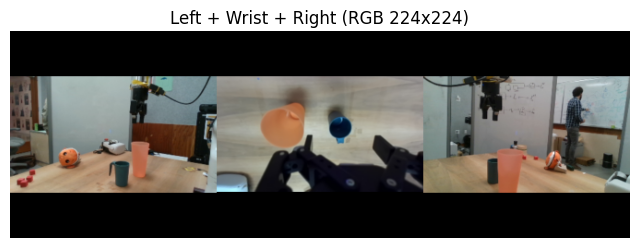

In [47]:

# img_left = cam_left.get_image()
# img_wrist = cam_wrist.get_image()
from openpi_client import image_tools

img_left = image_tools.resize_with_pad(
                        cam_left.get_image(), 224, 224
                    )
# img_wrist = image_tools.resize_with_pad(
#                         cam_wrist.get_image(), 224, 224
#                     )

img_wrist = image_tools.resize_with_pad(
                        zed_cam.get_image(), 224, 224
                    )

img_right = image_tools.resize_with_pad(
                        cam_right.get_image(), 224, 224
                    )

# combine the two images
combined = np.hstack((img_left, img_wrist, img_right))  # shape (224, 672, 3)

# display the combined image
plt.figure(figsize=(8, 4))
plt.imshow(combined)
plt.title("Left + Wrist + Right (RGB 224x224)")
plt.axis('off')
plt.show()





In [11]:
cam_left.release()
# cam_wrist.release()
cam_right.release()
zed_cam.release()

NameError: name 'cam_right' is not defined

In [59]:
# vla_policy_client
import Pyro5.api
import numpy as np
import time
from openpi_client import image_tools

ns = Pyro5.api.locate_ns()  # Locate the name server
uri = ns.lookup("pi0_controller")  # Use the name server to look up the URI
# uri = "PYRO:obj_556d727dadc34b1f8ca063985999cc83@localhost:36929"  # <-- change URI
controller = Pyro5.api.Proxy(uri)

# prompt
prompt = "pick the blue cup and place it"  # <-- change prompt

MAX_STEPS = 50000  # maximum number of steps to run
video_buffer = []  # buffer to store video frames

# dummy action
action = np.zeros((10,8), dtype=np.float32)
action_list = action.tolist()  # convert to list for sending

for step in range(MAX_STEPS):
    start = time.time()
    print(f"\n=== Step {step} ===")
    data_to_send = {
        "action": action_list,
        "step": step
    }
    start1 = time.time()
    print(f"Sending data to controller: {data_to_send}")
    obs = controller.step(data_to_send)
    end1 = time.time()
    print(f"Controller step took {end1 - start1:.2f} seconds")

    img_left = image_tools.resize_with_pad(
                            cam_left.get_image(), 224, 224
                        )
    # img_wrist = image_tools.resize_with_pad(
    #                         cam_wrist.get_image(), 224, 224
    #                     )
    img_wrist = image_tools.resize_with_pad(
                            zed_cam.get_image(), 224, 224
                        )
    img_right = image_tools.resize_with_pad(
                            cam_right.get_image(), 224, 224
                        )
    
    # save the images
    combined = np.hstack([img_left, img_right, img_wrist])
    video_buffer.append(combined)

    observation = {
        # "observation/exterior_image_1_left": np.array(obs["image_left"], dtype=np.uint8),
        # "observation/wrist_image_left": np.array(obs["image_wrist"], dtype=np.uint8),
        "observation/exterior_image_1_left": img_left,
        # "observation/exterior_image_1_left": np.zeros_like(img_left),  # dummy image for left
        "observation/wrist_image_left": img_wrist,
        # "observation/wrist_image_left": np.zeros_like(img_wrist),  # dummy image for wrist
        "observation/joint_position": np.array(obs["robot_state"], dtype=np.float32),
        "observation/gripper_position": np.array([obs["gripper_state"]], dtype=np.float32),  
        # "observation/joint_position": np.zeros_like(obs["robot_state"], dtype=np.float32),
        # "observation/gripper_position": np.zeros_like([obs["gripper_state"]], dtype=np.float32),  
        "prompt": prompt,
    }

    result = policy.infer(observation)
    action_list = result["actions"].tolist()
    end2 = time.time()
    print(f"Inference took {end2 - end1:.2f} seconds")
    print(f"Action at step {step}:", action_list[0])
    end = time.time()
    print(f"Step {step} took {end - start:.2f} seconds")



=== Step 0 ===
Sending data to controller: {'action': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], 'step': 0}
Controller step took 0.54 seconds
Inference took 0.14 seconds
Action at step 0: [-0.0931841903532549, -0.15929052070461516, 0.02024028396747025, 0.1390968908738953, 0.13816211465661066, -0.025611697742137778, 0.42555969081664874, -0.0017217906672298833]
Step 0 took 0.68 seconds

=== Step 1 ===
Sending data to controller: {'action': [[-0.0931841903532549, -0.15929052070461516, 0.02024028396747025, 0.1390968908738953, 0.13816211465661066, -0.025611697742137778, 0.42555969081664874, -0.0017217906672298833], [-

KeyboardInterrupt: 

## Todo
add text prompt to gif

In [41]:
import imageio
import cv2


gif_path = "pi0_droid_drawer_1.gif"
imageio.mimsave(gif_path, video_buffer, duration=0.1)
print(f"GIF saved:{gif_path}")

GIF saved:pi0_droid_drawer_1.gif


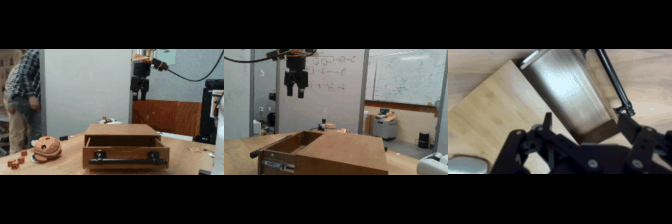

In [42]:
from IPython.display import Image
Image(filename="pi0_droid_drawer_1.gif")